---
title: "MSDS 597 Homework 3: NYC Air Quality Dashboard"
author:
- name: Vijitha Viswanathan 
  affiliation: Rutgers University, New Brunswick
format:
  html:
    code-fold: true
---

In [22]:
# the following package is needed to run the tests from your laptop,
# so that the tests can import the variables defined in this notebook.
#
# pip install ipynb

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns

## Q1: Parse XML into Pandas Dataframe

In the hw3 folder you will find the raw XML data ``air_quality.xml`` for the NYC air quality data obtained from [the NYC open data](https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data). 

Your task includes the following:

* Read the data description in the website linked above. Pay special attention to what each column means in the ``Columns (12)`` section.

* Parse the XML data and store it in a Pandas dataframe variable ``df``. Assign appropriate datatypes to eligible columns (e.g. dates, numeric values). Feel free to explore the dataframe and see what it contains.

In [24]:
# Your goal is to populate the following DataFrame:

## ----- TODO: Create a DataFrame from the XML data. ----
## Your code here:

import requests
import json
metadata_url = 'https://data.cityofnewyork.us/api/views/c3uy-2p5r.json'
response = requests.get(metadata_url)
metadata = response.json()
print("Column Descriptions:\n")
for column in metadata['columns']:
    name = column.get('name', 'No Name')
    description = column.get('description', 'No Description')
    print(f"Column: {name}\nDescription: {description}\n")
xml_file = "/Users/vijithaviswanathan/Desktop/Py_Script/hw3a-vijithaviswanathan/air_quality.xml"
try:
    with open(xml_file, 'r', encoding='utf-8') as f:
        xml_string = f.read()
    root = ET.fromstring(xml_string)
    rows = root.findall('.//row')  
    print(f"Total <row> elements found: {len(rows)}")  
    data = []
    for row in rows:
        row_data = {
            'row_id': row.get('_id'),  
            '_uuid': row.get('_uuid'),
            '_position': row.get('_position'),
            '_address': row.get('_address')
        }
        for child in row:  
            row_data[child.tag] = child.text.strip() if child.text else None
        data.append(row_data)
    df = pd.DataFrame(data)
    df = df.dropna(subset=['row_id'])
    if 'data_value' in df.columns:
        df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
    if 'start_date' in df.columns:
        df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
    print(df.head())  
    print(df.dtypes)
    specific_row = df[df['row_id'] == 'row-bd3j-mxka-rfdy']
    if not specific_row.empty:
        print(f"\nURL for row_id 'row-bd3j-mxka-rfdy': {specific_row['_address'].iloc[0]}")
    else:
        print("\nRow with row_id 'row-bd3j-mxka-rfdy' not found.")
except Exception as e:
    print(f"Error reading or parsing XML: {e}")


Column Descriptions:

Column: Unique ID
Description: Unique record identifier

Column: Indicator ID
Description: Identifier of the type of measured value across time and space

Column: Name
Description: Name of the indicator

Column: Measure
Description: How the indicator is measured

Column: Measure Info
Description: Information (such as units) about the measure

Column: Geo Type Name
Description: Geography type; UHF' stands for United Hospital Fund neighborhoods; For instance, Citywide, Borough, and Community Districts are different geography types

Column: Geo Join ID
Description: Identifier of the neighborhood geographic area, used for joining to mapping geography files to make thematic maps

Column: Geo Place Name
Description: Neighborhood name

Column: Time Period
Description: Description of the time that the data applies to ; Could be a year, range of years, or season for example

Column: Start_Date
Description: Date value for the start of the time_period; Always a date value; c

In [25]:
print(df.columns)

Index(['row_id', '_uuid', '_position', '_address', 'row', 'unique_id',
       'indicator_id', 'name', 'measure', 'measure_info', 'geo_type_name',
       'geo_join_id', 'geo_place_name', 'time_period', 'start_date',
       'data_value'],
      dtype='object')


## Q2: Annual average air quality by borough

This dataset contains information on New York City air quality surveillance data, across time and NYC geographies. According to the website, air pollution poses a significant environmental threat to urban populations. While everyone is exposed, pollutant emissions, exposure levels, and population vulnerability differ across neighborhoods. 

In the following exercises, we are interested in finding out geographical-temporal trends of the pollutant emissions in NYC. 

### Q2a: Data filtering

Your task includes the following:

* In a new dataframe ``pm_annual_avg``, obtain rows that contains borough-wise, annually-averaged information on the ``Fine particles (PM 2.5)`` indicator. The dataframe should cover information from 2009 to 2022.

* Calculate the annual city average ``Fine particles (PM 2.5)`` indicator values across all boroughs. Append the information to the end of the existing ``pm_annual_avg`` dataframe and assign the appended borough name to be ``New York City``.

*(Hint: you might want to take a look at the unique values for some of the columns. The description by columns on the website could be useful)*


In [26]:
required_columns = {'data_value', 'geo_place_name', 'start_date', 'name'}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")
df['time_period'] = df['start_date'].dt.year
pm_df = df[df['name'].str.contains(r"Fine particles \(PM 2\.5\)", regex=True, na=False)]
pm_df = pm_df[['time_period', 'geo_place_name', 'data_value']].rename(columns={'data_value': 'PM2.5'})
pm_df['PM2.5'] = pd.to_numeric(pm_df['PM2.5'], errors='coerce')
pm_df = pm_df[(pm_df['time_period'] >= 2009) & (pm_df['time_period'] <= 2022)]
borough_mapping = {
    'Bayside': 'Queens',
    'Bayside Little Neck': 'Queens',
    'Bayside and Little Neck': 'Queens',
    'Bedford Stuyvesant': 'Brooklyn',
    'Brooklyn': 'Brooklyn',
    'Bensonhurst': 'Brooklyn',
    'Bronx': 'Bronx',
    'Bushwick': 'Brooklyn',
    'Canarsie': 'Brooklyn',
    'Central Harlem': 'Manhattan',
    'Chelsea': 'Manhattan',
    'Coney Island': 'Brooklyn',
    'East Harlem': 'Manhattan',
    'East New York': 'Brooklyn',
    'East Flatbush': 'Brooklyn',
    'Flushing': 'Queens',
    'Greenpoint': 'Brooklyn',
    'Jamaica': 'Queens',
    'Kingsbridge': 'Bronx',
    'Manhattan': 'Manhattan',
    'South Ozone Park': 'Queens',
    'Upper East Side': 'Manhattan',
    'Upper West Side': 'Manhattan',
    'Washington Heights': 'Manhattan',
    'Williamsburg': 'Brooklyn',
    'Woodside': 'Queens',
}
pm_df['geo_place_name'] = pm_df['geo_place_name'].apply(lambda x: borough_mapping.get(x.strip(), 'Other'))
print("Unique borough values after mapping:")
print(pm_df['geo_place_name'].unique())
pm_annual_avg = pm_df.groupby(['time_period', 'geo_place_name'], as_index=False)['PM2.5'].mean()
city_avg = pm_annual_avg.groupby('time_period', as_index=False)['PM2.5'].mean()
city_avg['geo_place_name'] = 'New York City' 
pm_annual_avg = pd.concat([pm_annual_avg, city_avg], ignore_index=True)
print("Final shape of pm_annual_avg:", pm_annual_avg.shape)
print(pm_annual_avg.head())
assert pm_annual_avg.shape == (84, 3), f"Expected shape (84,3), but got {pm_annual_avg.shape}"

Unique borough values after mapping:
['Other' 'Manhattan' 'Brooklyn' 'Queens' 'Bronx']
Final shape of pm_annual_avg: (84, 3)
   time_period geo_place_name      PM2.5
0         2009          Bronx  10.600000
1         2009       Brooklyn  10.446667
2         2009      Manhattan  11.387500
3         2009          Other  10.500267
4         2009         Queens   9.700000


### Q2b: Visualization

Your task includes the following:
* Replicate [this lineplot](https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/air-quality/?id=2023#display=trend). Your plot doesn't have to be a 100% replicate, but it should contain similar information, including at least:

    * A title;

    * Axes labels including what the indicator measures and its corresponding unit, both axes in ascending order;

    * Lines with markers colored by boroughs (city average included);

    * A legend for the line colors.

Your plot will be manually graded.



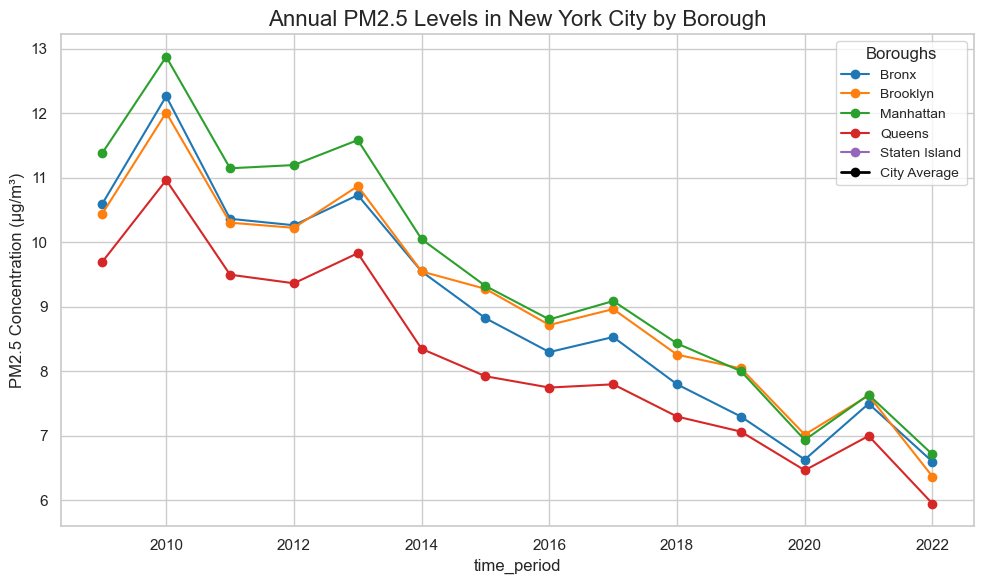

In [27]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
colors = sns.color_palette("tab10", len(boroughs))
for i, borough in enumerate(boroughs):
    borough_data = pm_annual_avg[pm_annual_avg['geo_place_name'] == borough]
    plt.plot(borough_data['time_period'], borough_data['PM2.5'], marker='o', color=colors[i], label=borough)
city_avg_data = pm_annual_avg[pm_annual_avg['geo_place_name'] == 'City Average']
plt.plot(city_avg_data['time_period'], city_avg_data['PM2.5'], marker='o', color='black', label='City Average', linewidth=2)
plt.title('Annual PM2.5 Levels in New York City by Borough', fontsize=16)
plt.xlabel('time_period', fontsize=12)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=12)
plt.legend(title="Boroughs", title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()

## Q3: Hospitalizations due to air quality


Exposure to common air pollutants has been associated with respiratory and cardiovascular diseases. To better understand air quality and its impact on health in the city, we take a closer look at these indicators over time and across NYC neighborhoods.

In the following exercise, you would repeat similar tasks as Q2. 

Your tasks include the following:

* Filter out rows that contain neighborhood-wise information on cardiovascular and respiratory hospitalizations. No need to obtain city average for each period.

* In two subplots side-by-side, plot the cardiovascular and respiratory hospitalization indicators across time and by neighborhood. Assign a different color to each neighborhood. Similar to before, include at least:

    * A title;

    * Axes labels including what these indicators measure and their corresponding units, both axes in ascending order;

    * Lines with markers colored by boroughs (city average included);

    * A legend for the line colors.

You may reuse your code from Q2.

Cardiovascular hospitalizations: 25 rows
Respiratory hospitalizations: 25 rows


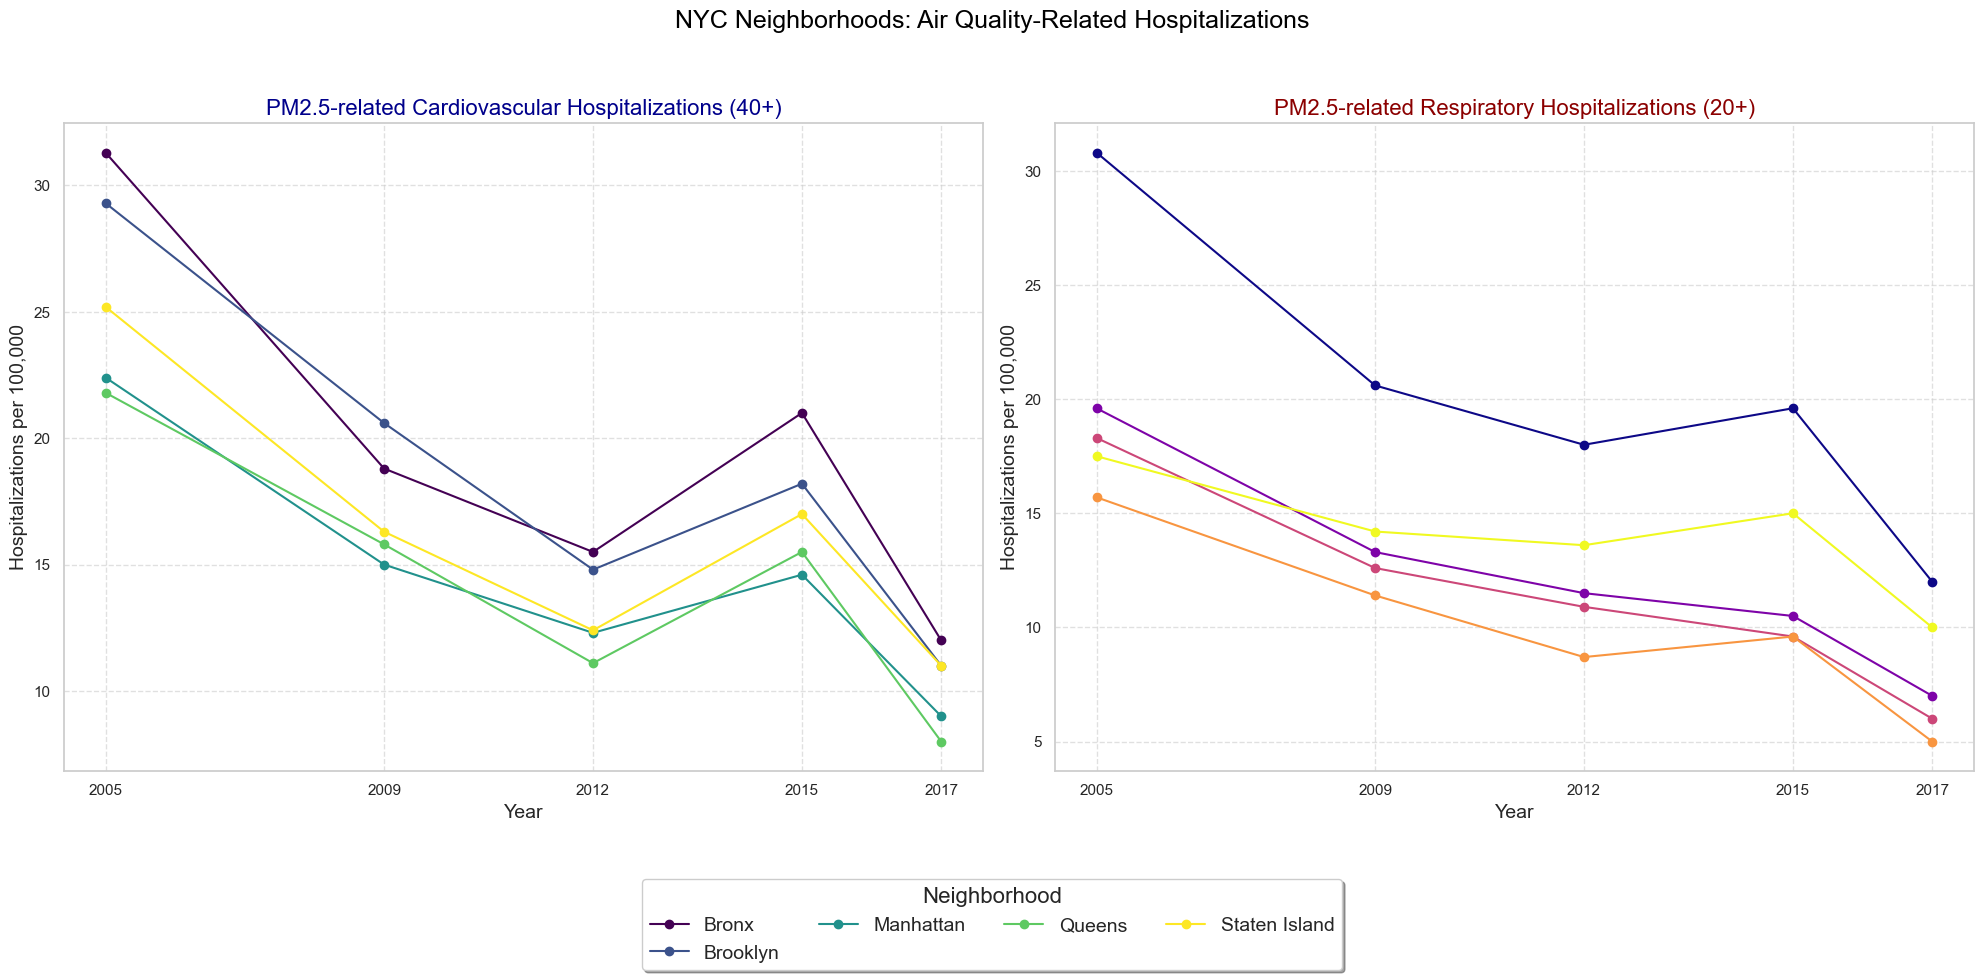

In [28]:
df_cardiovascular = df[(df['name'].str.contains('Cardiovascular')) & 
                 (df['geo_type_name'] == 'Borough')].copy()
df_respiratory = df[(df['name'].str.contains('Respiratory')) & 
               (df['geo_type_name'] == 'Borough')].copy()
df_cardiovascular['year_recorded'] = pd.to_datetime(df_cardiovascular['start_date']).dt.year
df_respiratory['year_recorded'] = pd.to_datetime(df_respiratory['start_date']).dt.year
print(f"Cardiovascular hospitalizations: {len(df_cardiovascular)} rows")
print(f"Respiratory hospitalizations: {len(df_respiratory)} rows")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
neighborhoods = sorted(set(df_cardiovascular['geo_place_name'].unique()) | 
                       set(df_respiratory['geo_place_name'].unique()))
color_palette_cardio = plt.cm.viridis(np.linspace(0, 1, len(neighborhoods)))
color_palette_resp = plt.cm.plasma(np.linspace(0, 1, len(neighborhoods)))
color_mapping_cardio = dict(zip(neighborhoods, color_palette_cardio))
color_mapping_resp = dict(zip(neighborhoods, color_palette_resp))
for area in neighborhoods:
    cardio_data = df_cardiovascular[df_cardiovascular['geo_place_name'] == area]
    if not cardio_data.empty:
        cardio_data = cardio_data.sort_values('year_recorded')
        axes[0].plot(cardio_data['year_recorded'], cardio_data['data_value'], 
                     marker='o', linestyle='-', color=color_mapping_cardio[area], label=area)
for area in neighborhoods:
    resp_data = df_respiratory[df_respiratory['geo_place_name'] == area]
    if not resp_data.empty:
        resp_data = resp_data.sort_values('year_recorded')
        axes[1].plot(resp_data['year_recorded'], resp_data['data_value'], 
                     marker='o', linestyle='-', color=color_mapping_resp[area], label=area)
axes[0].set_title('PM2.5-related Cardiovascular Hospitalizations (40+)', fontsize=16, color='darkblue')
axes[0].set_xlabel('Year', fontsize=14)
axes[0].set_ylabel('Hospitalizations per 100,000', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('PM2.5-related Respiratory Hospitalizations (20+)', fontsize=16, color='darkred')
axes[1].set_xlabel('Year', fontsize=14)
axes[1].set_ylabel('Hospitalizations per 100,000', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(sorted(df_cardiovascular['year_recorded'].unique()))
axes[1].set_xticks(sorted(df_respiratory['year_recorded'].unique()))
handles, labels = axes[0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.3)
legend = fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01),
                    ncol=4, fontsize=14, title="Neighborhood", frameon=True, shadow=True)
legend.get_title().set_fontsize(16)
fig.suptitle('NYC Neighborhoods: Air Quality-Related Hospitalizations', fontsize=18, color='black')
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()